# Decision Trees
- The idea behind DTree is to break classification down into a set of choices about each entry in our feature vector.
- We can actually visualize and interpret the choice a tree is making and follow the path it is taking from the root to a leaf.
- Refer Andrew NG DTree explanation.
- The first step in constructing a decision tree is to decide which feature is split on to form the rest of the tree. In this step, all we are doing is forming the root of the tree.
- To decide which feature to split on, we try every feature (i.e. column) and measure which split gives us the most “information” — this is called our most informative split. The most informative split is dictated by which algorithm we are using to construct the tree but is normally information gain or the Gini ratio/coefficient.
- We repeat the process of finding the most informative split, split on said that feature, and continue down the tree. This process is repeated until we can classify all instances correctly.
***

# Random Forests (Rf)
- By constructing multiple decision trees and injecting a little bit of randomness, we can actually improve our classification accuracy.
- Rf are a type of ensemble classification method- instead of using only one classifer we use multiple classifiers that are aggregated into one big meta-classifier
- Each decision tree “votes” on what it thinks the final classification is. These votes are tabulated by the meta-classifier, and the category with the most votes is chosen as the final classification.
- **Jensen's Inequality**: we can be assured that the average of all models will perform no worse than selecting any single model at random
- **Bootstrapping: inject a little randomness**: Rf classifiers train each DTree on a bootstrap sample from original training data. 
    - Basically means sampling with replacement D times from our training data. 
    - Normally, D is equal to number of data points in training set.
    - Sample with replacement a total of D times, implies that some feature vectors will be included multiple times and other feature vectors will not be included at all. Applying this type of sampling scheme obtains near-optimal performance in most cases.
- **Randomness in node splits**:
    - Random selection at individual feature level.
    - For each decision block in the tree, the node split function only has a portion of the total number of features to work with.
    - Number of randomly selected features(without replacement) is either $\sqrt(\#features)$ or $log(\#features)$
    - Say for example, we have 10-d feature vector. At each decision node, we select individual features that node split function is going to use to determine the most optimal split. So, we randomly sample $\sqrt(10)\approx4$ features. 
    - Bootstrapping followed by allowing only subset of features to be used at each node in tree allows use to avoid overfitting.
- **Aggregating votes**: 
    - Aggregating a set of decision trees constructed from bootstrapped samples yields a random forest. 
    - Each tree can therefore produce two types of outputs: either a vote indicating that the tree believes the input feature vector belongs to a given class, or a probability distribution for each class label. The votes/probability distributions are then aggregated by the meta-ensemble, and the final classification is obtained.
    
***
# Classify scenes
- We have N images of four scenes including: coasts, forests, highways, and streets.
- Extract features from these images and construct a decision tree classifier that can recognize and discriminate amongst these four classes
- Extract both color and texture features together inside a single feature vector.

In [1]:
import sys
sys.path.append("../../")

In [2]:
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from imutils import paths
import numpy as np
import argparse
import mahotas
import cv2
import sklearn
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from cv_imshow import create_subplot

In [3]:
def describe(image):
    #extract mean and stddev for each channel of image in hsv color space.
    (means, stds) = cv2.meanStdDev(cv2.cvtColor(image, cv2.COLOR_BGR2HSV))
    colorStats = np.concatenate([means, stds]).flatten()
    
    #extract haralick texture features
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    
    return np.hstack([colorStats, haralick])

In [4]:
args = {
    "dataset":"../../images/dt_and_rf/4scenes/",
    "forest":-1
}

In [5]:
def get_split():
    imagePaths = sorted(paths.list_images(args["dataset"]))
    labels = []
    data = []

    for imagePath in imagePaths:
        label = imagePath[imagePath.rfind("/")+1:].split("_")[0]
        image = cv2.imread(imagePath)

        features = describe(image)
        labels.append(label)
        data.append(features)

    (trainData, testData, trainLabels, testLabels) = train_test_split(np.array(data), np.array(labels),
                                                                      test_size=0.25,random_state=42)
    
    return (trainData, testData, trainLabels, testLabels)

In [6]:
def model_fit(isForest=False):

    model = DecisionTreeClassifier(random_state=84)

    # check to see if a Random Forest should be used instead
    if isForest:
        model = RandomForestClassifier(n_estimators=20, random_state=42)
    
    return model

In [7]:
# train the decision tree
print("[INFO] training model...")
model = model_fit()
(trainData, testData, trainLabels, testLabels) = get_split()
model.fit(trainData, trainLabels)

[INFO] training model...


DecisionTreeClassifier(random_state=84)

In [8]:
print("[INFO] evaluating...")
predictions = model.predict(testData)
print(classification_report(testLabels, predictions))

[INFO] evaluating...
              precision    recall  f1-score   support

       coast       0.75      0.71      0.73        93
      forest       0.92      0.87      0.89        87
     highway       0.68      0.71      0.70        63
      street       0.77      0.84      0.80        67

    accuracy                           0.78       310
   macro avg       0.78      0.78      0.78       310
weighted avg       0.79      0.78      0.78       310



[PREDICTION] coast_natu643.jpg: coast
[PREDICTION] street_gre211.jpg: street
[PREDICTION] highway_bost184.jpg: highway
[PREDICTION] coast_nat1149.jpg: coast
[PREDICTION] forest_natu847.jpg: forest
[PREDICTION] highway_urb715.jpg: highway
[PREDICTION] coast_natu408.jpg: coast
[PREDICTION] highway_gre683.jpg: highway
[PREDICTION] coast_n291076.jpg: coast
[PREDICTION] coast_open13.jpg: coast


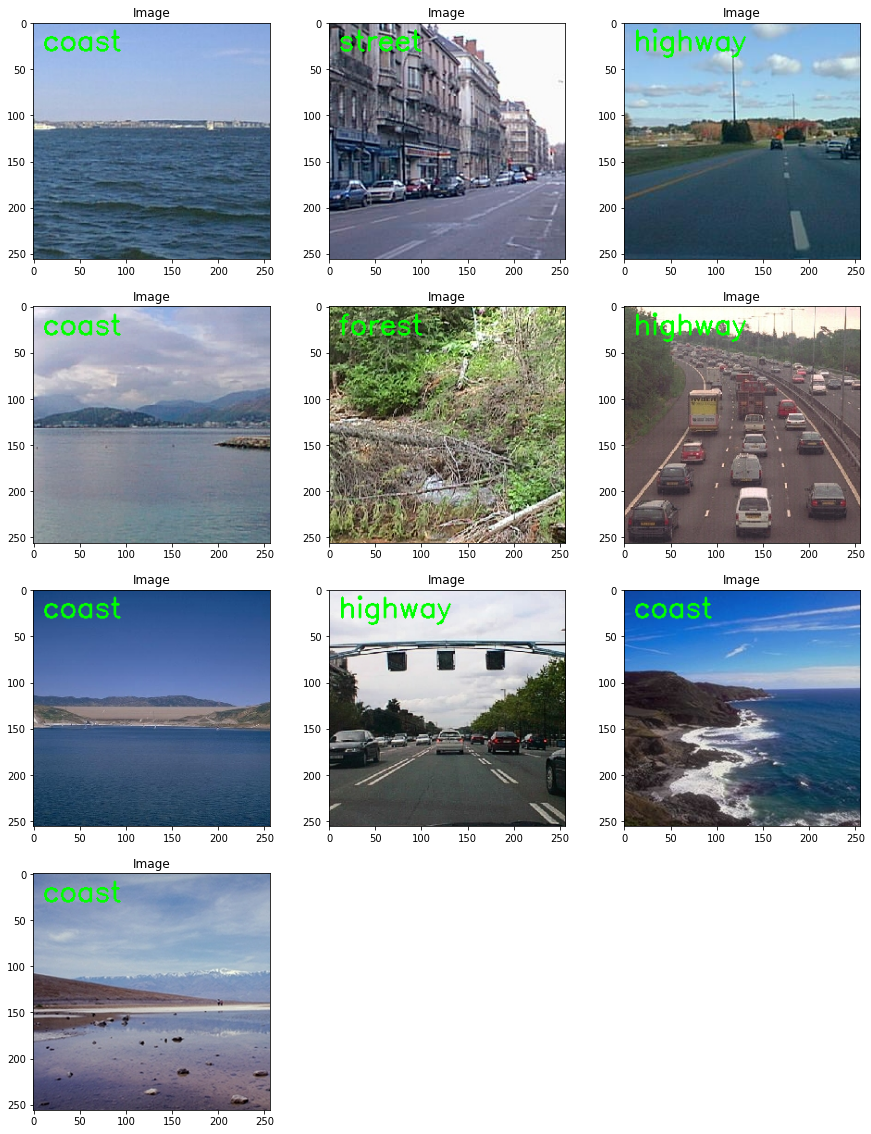

In [12]:
fig = plt.figure(figsize=(15,20))
rows = 4
columns = 3
j = 1
imagePaths = sorted(paths.list_images(args["dataset"]))
for i in np.random.randint(0, high=len(imagePaths), size=(10,)):
    # grab the image and classify it
    imagePath = imagePaths[i]
    filename = imagePath[imagePath.rfind("/") + 1:]
    image = cv2.imread(imagePath)
    features = describe(image)
    prediction = model.predict(features.reshape(1, -1))[0]
 
    # show the prediction
    print("[PREDICTION] {}: {}".format(filename, prediction))
    cv2.putText(image, prediction, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2)
    create_subplot(fig, rows, columns, j, "Image", image)
    j += 1

In [13]:
# train the decision tree
print("[INFO] training model...")
model = model_fit(isForest=True)
model.fit(trainData, trainLabels)

[INFO] training model...


RandomForestClassifier(n_estimators=20, random_state=42)

In [14]:
print("[INFO] evaluating...")
predictions = model.predict(testData)
print(classification_report(testLabels, predictions))

[INFO] evaluating...
              precision    recall  f1-score   support

       coast       0.83      0.82      0.82        93
      forest       0.93      0.93      0.93        87
     highway       0.85      0.70      0.77        63
      street       0.76      0.90      0.82        67

    accuracy                           0.84       310
   macro avg       0.84      0.84      0.83       310
weighted avg       0.85      0.84      0.84       310

